In [179]:
# %% imports
from typing import List

import scipy
import scipy.io
import scipy.stats

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from gaussparams import GaussParams
from mixturedata import MixtureParameters
import dynamicmodels
import measurementmodels
import ekf
import imm
import pda
import estimationstatistics as estats

In [193]:
# %% plot config check and style setup
# to see your plot config
print(f"matplotlib backend: {matplotlib.get_backend()}")
print(f"matplotlib config file: {matplotlib.matplotlib_fname()}")
print(f"matplotlib config dir: {matplotlib.get_configdir()}")
plt.close("all")

# set styles
try:
    # installed with "pip install SciencePLots" (https://github.com/garrettj403/SciencePlots.git)
    # gives quite nice plots
    plt_styles = ["science", "grid", "bright", "no-latex"]
    plt.style.use(plt_styles)
    print(f"pyplot using style set {plt_styles}")
except Exception as e:
    print(e)
    print("setting grid and only grid and legend manually")
    plt.rcParams.update(
        { 
            # setgrid
            "axes.grid": True,
            "grid.linestyle": ":",
            "grid.color": "k",
            "grid.alpha": 0.5,
            "grid.linewidth": 0.5,
            # Legend
            "legend.frameon": True,
            "legend.framealpha": 1.0,
            "legend.fancybox": True,
            "legend.numpoints": 1,
        }
    )

matplotlib backend: module://ipykernel.pylab.backend_inline
matplotlib config file: c:\users\jeg_j\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\mpl-data\matplotlibrc
matplotlib config dir: C:\SPB_Data\.matplotlib
pyplot using style set ['science', 'grid', 'bright', 'no-latex']


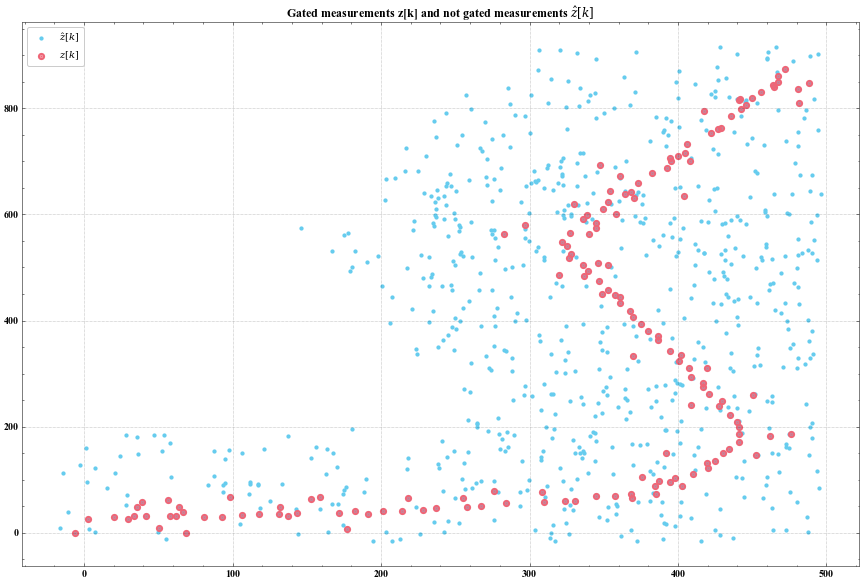

In [194]:
# %% load data and plot
filename_to_load = "data_for_imm_pda.mat"
loaded_data = scipy.io.loadmat(filename_to_load)
K   = loaded_data["K"].item()
Ts  = loaded_data["Ts"].item()
Xgt = loaded_data["Xgt"].T
Z   = [zk.T for zk in loaded_data["Z"].ravel()]
true_association = loaded_data["a"].ravel()

# plot measurements close to the trajectory
fig1, ax1 = plt.subplots(num=1, clear=True, figsize=(15,10))

Z_gated_data = np.empty((0, 2), dtype=float)
Z_ungated_data = np.empty((0, 2), dtype=float)
gate_limit = 4*2
for Zk, xgtk in zip(Z, Xgt):
    meas_dist = np.linalg.norm(Zk - xgtk[None:2], axis=1)
    gated_meas = meas_dist <= gate_limit**1.8
    ungated_meas = meas_dist < gate_limit**2.5
    Z_gated_data = np.append(Z_gated_data, Zk[gated_meas], axis=0)
    Z_ungated_data = np.append(Z_ungated_data, Zk[ungated_meas], axis=0)

ax1.scatter(*Z_ungated_data.T, s=5, color="C4", linewidths=2, label="$\hat z[k]$")
ax1.scatter(*Z_gated_data.T, s=5, color="C1", linewidths=5, label="$z[k]$")
#ax1.plot(*Xgt.T[:2], color="C0", linewidth=2, label="$x$")
ax1.legend(loc = 'upper left')
ax1.set_title("Gated measurements z[k] and not gated measurements $\hat z[k]$")
plt.show(block=False)


In [195]:
# Example of a naive init_scheme for CV model. This is loosely based on M/N logic. 
# Does not account for mode probabilities. Also does not work real time, as it sets init. position as the first measurement.
# Init_radius and init_guess could be determined from GNSS. 
def naive_mean_cv(N:int, M:int, init_radius:float, init_guess:tuple, gate:float, Ts:float):
    if M>N or N<2: 
        return
    
    potential_Zs = [] # list of list of measurement-series
    for z in Z[0]:
        d = init_radius**2 - ((init_guess[0]-z[0])**2 + (init_guess[1]-z[1])**2)
        if d >= 0:
            potential_Zs.append([tuple(z)])
    
    gate_size = gate
    
    # Uses the latest measurement in close vicinity of previous, to gate the next measurements.
    for m in range(1,N):
        for z_series in potential_Zs:
            # Predicts centre of cov-ellipse of new measurement based on constant velocity model
            if len(z_series) > 1:
                new_center = (2*z_series[-1][0]-z_series[-2][0], 2*z_series[-1][1]-z_series[-2][1])
                gate_size = 0.5*gate #Makes the new gate smaller as we now have better prediction (only happens once)
            else:
                new_center = z_series[-1]
            for z in Z[m]: 
                d = (gate_size)**2 - ((float(new_center[0])-z[0])**2 + (float(new_center[1])-z[1])**2)
                if d >=0:
                    z_series.append(tuple(z))  
                    
        
    num_possible_series = len(list(filter(lambda x: len(x) >= M, potential_Zs)))
    if num_possible_series > 1:
        print("error: Several trajectories possible")
        return
    
    meas_0, meas_1 = potential_Zs[0][0], potential_Zs[0][1]
    x, y           = meas_0[0], meas_0[1]
    velx, vely     = (meas_1[0]-meas_0[0])/Ts, (meas_1[1]-meas_0[1])/Ts
    
    return np.array((x, y, velx, vely))
    
naive_mean = naive_mean_cv(N=4, M=4, init_radius=50, init_guess=(0, 20), gate=20, Ts=Ts)
print("Naive mean: ", naive_mean)

Naive mean:  [ 2.46850281 24.68253298  7.08459833  1.514655  ]


In [196]:
# %% IMM-PDA

# THE PRESET PARAMETERS AND INITIAL VALUES WILL CAUSE TRACK LOSS! Some reasoning and previous exercises should let you avoid track loss.
# No exceptions should be generated if PDA works correctly with IMM,  but no exceptions do not guarantee correct implementation.

# sensor
sigma_z           =  #1.8 #2 # 1.7
clutter_intensity = 1e-4 #1e-4 #1e-4 #1e-3
PD                = 0.9 #0.8 #0.9 # 0.8
gate_size         = 4

# dynamic models
sigma_a_CV = 0.07 #0.15 #0.05 # # 0.15
sigma_a_CT = 0.09 #0.15 #0.07 # 0.15
sigma_omega = 0.02 #0.01 #0.02

# markov chain
PI11 = 0.95 #0.95 0.90
PI22 = 0.95 #0.95 0.90

p10 = 0.9 #0.8  # 0.9 initvalue for mode probabilities

PI = np.array([[PI11, (1 - PI11)], [(1 - PI22), PI22]])
assert np.allclose(np.sum(PI, axis=1), 1), "rows of PI must sum to 1"

mean_init               = np.array([0, 20, 0, 0, 0])
cov_init                = np.diag([sigma_z, sigma_z, 7, 7, 0.5]) ** 2 
mode_probabilities_init = np.array([p10, (1 - p10)])
mode_states_init        = GaussParams(mean_init, cov_init)
init_imm_state          = MixtureParameters(mode_probabilities_init, [mode_states_init] * 2)

assert np.allclose(
    np.sum(mode_probabilities_init), 1
), "initial mode probabilities must sum to 1"

# make model
measurement_model = measurementmodels.CartesianPosition(sigma_z, state_dim=5)
dynamic_models: List[dynamicmodels.DynamicModel] = []
dynamic_models.append(dynamicmodels.WhitenoiseAccelleration(sigma_a_CV, n=5))
dynamic_models.append(dynamicmodels.ConstantTurnrate(sigma_a_CT, sigma_omega))
ekf_filters = []
ekf_filters.append(ekf.EKF(dynamic_models[0], measurement_model))
ekf_filters.append(ekf.EKF(dynamic_models[1], measurement_model))
imm_filter  = imm.IMM(ekf_filters, PI)
tracker     = pda.PDA(imm_filter, clutter_intensity, PD, gate_size)

NEES    = np.zeros(K)
NEESpos = np.zeros(K)
NEESvel = np.zeros(K)


tracker_update        = init_imm_state
tracker_update_list   = []
tracker_predict_list  = []
tracker_estimate_list = []
# estimate
for k, (Zk, x_true_k) in enumerate(zip(Z, Xgt)):
    tracker_predict  = tracker.predict(tracker_update, Ts)
    tracker_update   = tracker.update(Zk, tracker_predict)

    prediction_estimate = tracker.estimate(tracker_predict)
    tracker_estimate    = tracker.estimate(tracker_update)

    NEES[k]    = estats.NEES(*tracker_estimate, x_true_k, idxs=np.arange(4))
    NEESpos[k] = estats.NEES(*tracker_estimate, x_true_k, idxs=np.arange(2))
    NEESvel[k] = estats.NEES(*tracker_estimate, x_true_k, idxs=np.arange(2, 4))

    tracker_predict_list.append(tracker_predict)
    tracker_update_list.append(tracker_update) 
    tracker_estimate_list.append(tracker_estimate)

x_hat    = np.array([est.mean for est in tracker_estimate_list])
prob_hat = np.array([upd.weights for upd in tracker_update_list])

# calculate a performance metrics
poserr  = np.linalg.norm(x_hat[:, :2] - Xgt[:, :2], axis = 1) #0)
velerr  = np.linalg.norm(x_hat[:, 2:4] - Xgt[:, 2:4], axis = 1) #0)
posRMSE = np.sqrt(np.mean(poserr ** 2)) # not true RMSE (which is over monte carlo simulations)
velRMSE = np.sqrt(np.mean(velerr ** 2)) # not true RMSE (which is over monte carlo simulations)
peak_pos_deviation = poserr.max()
peak_vel_deviation = velerr.max()


# consistency
confprob = 0.9
CI2 = np.array(scipy.stats.chi2.interval(confprob, 2))
CI4 = np.array(scipy.stats.chi2.interval(confprob, 4))

CI2K = np.array(scipy.stats.chi2.interval(confprob, 2 * K)) / K
CI4K = np.array(scipy.stats.chi2.interval(confprob, 4 * K)) / K
ANEESpos = np.mean(NEESpos)
ANEESvel = np.mean(NEESvel)
ANEES    = np.mean(NEES)

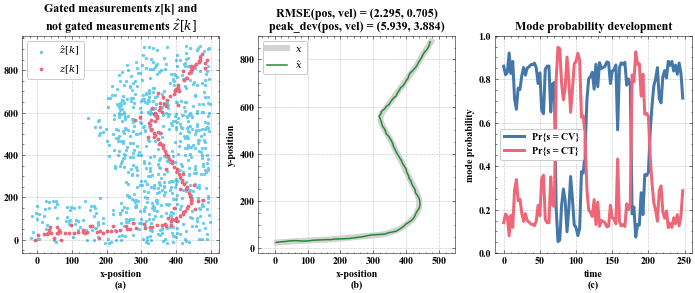

In [199]:
# %% plots
# trajectory
fig3, axs3 = plt.subplots(1, 3, num=3, clear=True, figsize=(12,4))
axs3[1].plot(*Xgt.T[:2], label="$x$", color="lightgrey", linewidth=6)
axs3[1].plot(*x_hat.T[:2], label=r"$\hat x$", color="C2", linewidth=1.5)
axs3[1].legend()
axs3[1].set_title(
    f"RMSE(pos, vel) = ({posRMSE:.3f}, {velRMSE:.3f})\npeak_dev(pos, vel) = ({peak_pos_deviation:.3f}, {peak_vel_deviation:.3f})"
)
axs3[1].set_xlim([-50, 550])
axs3[1].set_ylim([-20, 900])
axs3[1].set_ylabel("y-position")
axs3[1].set_xlabel("x-position\n(b)")

# probabilities
axs3[2].plot(np.arange(K) * Ts, prob_hat[:,0], label="Pr{s = CV}", linewidth = 3)
axs3[2].plot(np.arange(K) * Ts, prob_hat[:,1], label="Pr{s = CT}", linewidth = 3)
axs3[2].legend()
axs3[2].set_ylim([0, 1])
axs3[2].set_title("Mode probability development")
axs3[2].set_ylabel("mode probability")
axs3[2].set_xlabel("time\n(c)")

axs3[0].scatter(*Z_ungated_data.T, s=5, color="C4", linewidths=1, label="$\hat z[k]$")
axs3[0].scatter(*Z_gated_data.T, s=5, color="C1", linewidths=1.5, label="$z[k]$")
axs3[0].legend(loc = 'upper left')
axs3[0].set_title("Gated measurements z[k] and\nnot gated measurements $\hat z[k]$")
axs3[0].set_xlabel("x-position\n(a)")

fig3.savefig("task2_new_rmse_figs.pdf", format="pdf")

ANEESpos = 2.23 with CI = [1.68, 2.34]
ANEESvel = 1.85 with CI = [1.68, 2.34]
ANEES = 3.97 with CI = [3.55, 4.48]


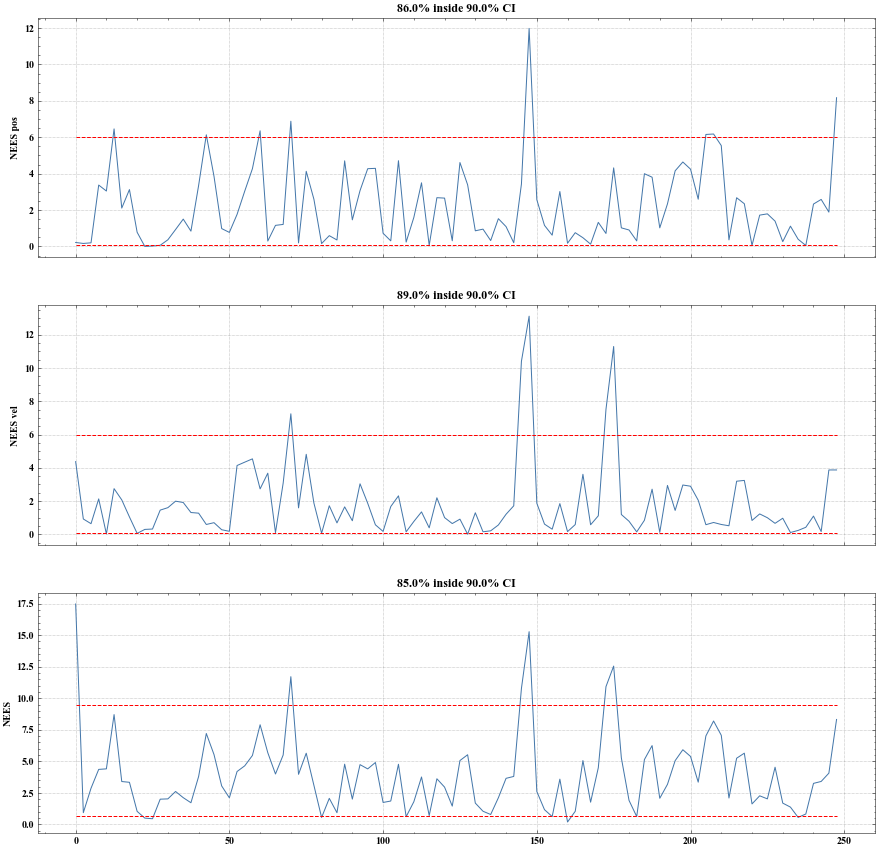

In [191]:
# NEES
fig4, axs4 = plt.subplots(3, sharex=True, num=4, clear=True, figsize=(15,15))
axs4[0].plot(np.arange(K) * Ts, NEESpos)
axs4[0].plot([0, (K - 1) * Ts], np.repeat(CI2[None], 2, 0), "--r")
axs4[0].set_ylabel("NEES pos")
inCIpos = np.mean((CI2[0] <= NEESpos) * (NEESpos <= CI2[1]))
axs4[0].set_title(f"{inCIpos*100:.1f}% inside {confprob*100:.1f}% CI")

axs4[1].plot(np.arange(K) * Ts, NEESvel)
axs4[1].plot([0, (K - 1) * Ts], np.repeat(CI2[None], 2, 0), "--r")
axs4[1].set_ylabel("NEES vel")
inCIvel = np.mean((CI2[0] <= NEESvel) * (NEESvel <= CI2[1]))
axs4[1].set_title(f"{inCIvel*100:.1f}% inside {confprob*100:.1f}% CI")

axs4[2].plot(np.arange(K) * Ts, NEES)
axs4[2].plot([0, (K - 1) * Ts], np.repeat(CI4[None], 2, 0), "--r")
axs4[2].set_ylabel("NEES")
inCI = np.mean((CI4[0] <= NEES) * (NEES <= CI4[1]))
axs4[2].set_title(f"{inCI*100:.1f}% inside {confprob*100:.1f}% CI")

print(f"ANEESpos = {ANEESpos:.2f} with CI = [{CI2K[0]:.2f}, {CI2K[1]:.2f}]")
print(f"ANEESvel = {ANEESvel:.2f} with CI = [{CI2K[0]:.2f}, {CI2K[1]:.2f}]")
print(f"ANEES = {ANEES:.2f} with CI = [{CI4K[0]:.2f}, {CI4K[1]:.2f}]")

Text(0, 0.5, 'velocity error')

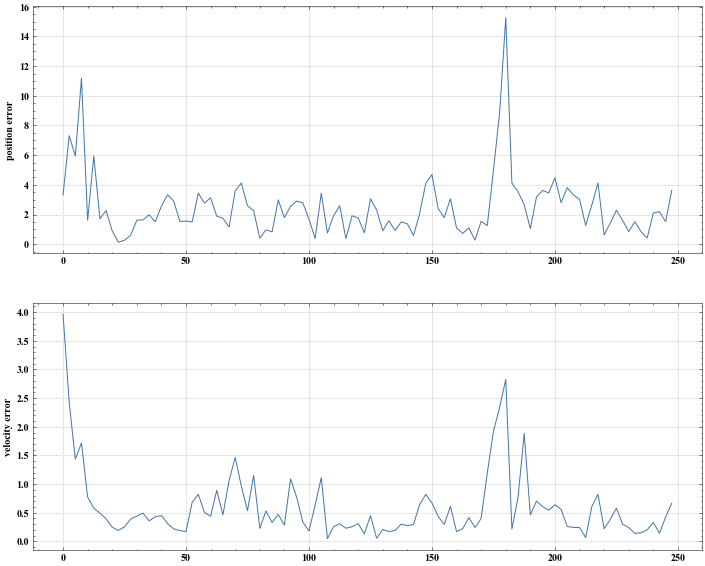

In [186]:
# errors
fig5, axs5 = plt.subplots(2, num=5, clear=True, figsize=(12,10))
axs5[0].plot(np.arange(K) * Ts, np.linalg.norm(x_hat[:, :2] - Xgt[:, :2], axis=1))
axs5[0].set_ylabel("position error")

axs5[1].plot(np.arange(K) * Ts, np.linalg.norm(x_hat[:, 2:4] - Xgt[:, 2:4], axis=1))
axs5[1].set_ylabel("velocity error")